# CVAI Project - ZAUBI

In [1]:
import pandas as pd
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import re
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

/Users/outofshape/Projects/hslu_cvai_zaubi/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing

### Data Collection

In [3]:
# # load the dataset from huggingface
# dataset = load_dataset("mtg_image_data", split="train")

# # save the dataset to disk
# dataset.save_to_disk("data/mtg-image-data")

# load the dataset from disk
dataset = load_from_disk("data/mtg-image-data")
dataset

Dataset({
    features: ['image', 'Unnamed: 0', 'text'],
    num_rows: 27000
})

In [4]:
df = dataset.to_pandas()
df.head()

,image,Unnamed: 0,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17785,"MTG card art, +2 Mace, by Jarel Threat, 2021, ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4372,"MTG card art, A-Ardent Dustspeaker, by Mads Ah..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,25418,"MTG card art, A-Baba Lysaga, Night Witch, by S..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6378,"MTG card art, A-Binding Geist, by Campbell Whi..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,21834,"MTG card art, A-Brine Comber, by Olena Richard..."


In [5]:
df.dtypes

image         object
Unnamed: 0     int64
text          object
dtype: object

### Feature Engineering

#### Label extraction

In [6]:
# Extract the labels (U, B, W, G, R, C) from the text, searching for pattern like ', U,' and the new feature with name "mana_color"

def replace_label(label):
    label = label.replace('C', 'colorless')
    label = label.replace('U', 'blue')
    label = label.replace('B', 'black')
    label = label.replace('W', 'white')
    label = label.replace('G', 'green')
    label = label.replace('R', 'red')
    return label

def extract_label(text):
    labels = re.findall(r", (U|B|W|G|R|C),", text)
    label = pd.NA if len(labels) == 0 else replace_label(labels[0])
    return label
# Add the extracted features to the dataframe
df['mana_color'] = df['text'].apply(extract_label)
df.head()

,image,Unnamed: 0,text,mana_color
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17785,"MTG card art, +2 Mace, by Jarel Threat, 2021, ...",white
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4372,"MTG card art, A-Ardent Dustspeaker, by Mads Ah...",red
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,25418,"MTG card art, A-Baba Lysaga, Night Witch, by S...",<NA>
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6378,"MTG card art, A-Binding Geist, by Campbell Whi...",blue
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,21834,"MTG card art, A-Brine Comber, by Olena Richard...",<NA>


In [7]:
df.isna().sum()

image            0
Unnamed: 0       0
text             0
mana_color    3152
dtype: int64

In [8]:
df.dropna(inplace=True)
df.drop(columns=['text'], inplace=True)
df.isna().sum()

image         0
Unnamed: 0    0
mana_color    0
dtype: int64

In [9]:
df.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df.id.duplicated().sum()

0

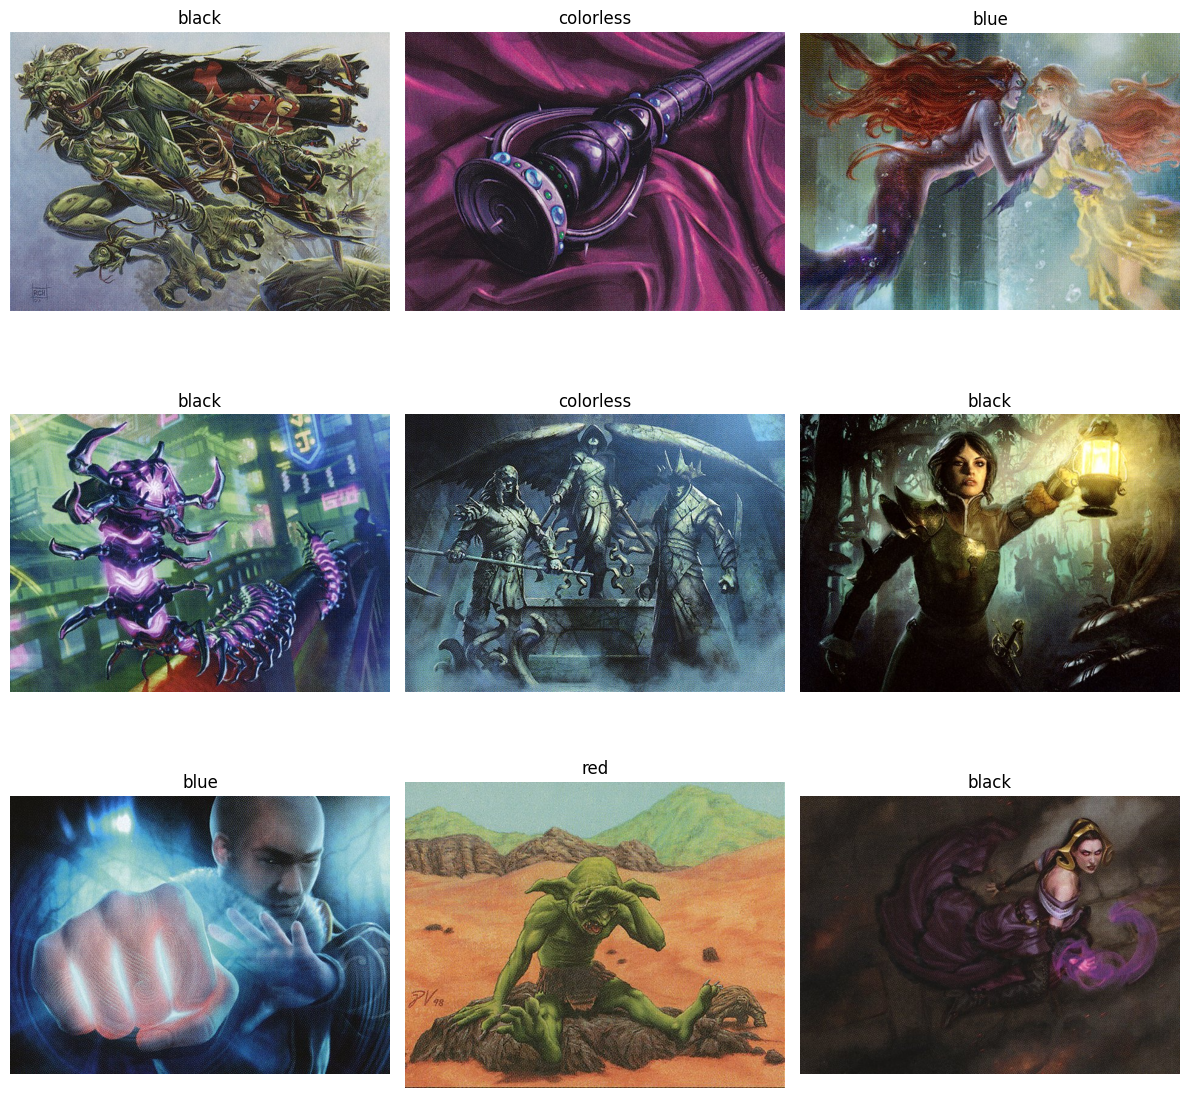

In [10]:
# Define a function to visualize images (in {'bytes': b....} format)
def visualize_images(df, num_images=9, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i in range(num_images):
        idx = random.randint(0, len(df))
        img = Image.open(io.BytesIO(df.iloc[idx]["image"]["bytes"]))
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.title.set_text(df.iloc[idx]["mana_color"])
    plt.tight_layout()
    plt.show()

# Visualize some random images from the dataset
visualize_images(df)


#### One-hot encoding

In [11]:
# one-hot encode the mana_color feature
df = pd.get_dummies(df, columns=['mana_color'], dtype=int)
print(df.shape)
df.head()

(23848, 8)


,image,id,mana_color_black,mana_color_blue,mana_color_colorless,mana_color_green,mana_color_red,mana_color_white
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17785,0,0,0,0,0,1
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4372,0,0,0,0,1,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6378,0,1,0,0,0,0
6,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,19254,0,0,0,0,0,1
8,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5909,0,0,0,0,1,0


#### Train Validation Split

In [25]:
# prepare the data for training and testing
train, validation = train_test_split(df, test_size=0.2, random_state=42)
train.shape, validation.shape

((19078, 8), (4770, 8))

## Model Building

### Load the pre-trained model

In [26]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Initialize the Weight Transform
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Apply it to the input image
def preprocess_image(image):
    img = Image.open(io.BytesIO(image["bytes"]))
    return preprocess(img)

model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [27]:
# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

In [28]:
# Modify the last layer to fit the number of classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(df.columns)-2)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# transform the images
train['image'] = train['image'].apply(preprocess_image)
train.head()

,image,id,mana_color_black,mana_color_blue,mana_color_colorless,mana_color_green,mana_color_red,mana_color_white
12773,"[[[tensor(1.7865), tensor(1.8722), tensor(1.97...",10072,0,0,0,0,1,0
17774,"[[[tensor(-0.6623), tensor(-0.6794), tensor(-0...",20857,0,1,0,0,0,0
9919,"[[[tensor(1.4098), tensor(1.4269), tensor(1.39...",1549,0,0,0,1,0,0
6461,"[[[tensor(-0.8507), tensor(-0.8678), tensor(-1...",7912,0,0,0,1,0,0
17385,"[[[tensor(-1.0562), tensor(-0.9363), tensor(-1...",16569,0,0,1,0,0,0


In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# dataloader for training and validation
train_loader = torch.utils.data.DataLoader(train.drop(columns=["id"]), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation.drop(columns=["id"]), batch_size=32, shuffle=False)

AttributeError: 'function' object has no attribute 'drop'

In [19]:
# define training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train)
        train_acc = running_corrects.double() / len(train)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(validation)
        val_acc = running_corrects.double() / len(validation)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        

In [20]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


KeyError: 15918